In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [ ]:
data_dir = '/Users/franciszeklasinski/Desktop/dogvscat /archive-2/train'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

class_names = dataset.classes
print("Klasy:", class_names)
print("Liczba próbek w zbiorze:", len(dataset))

Klasy: ['cats', 'dogs']
Liczba próbek w zbiorze: 20000


Przykładowe zdjęcia:


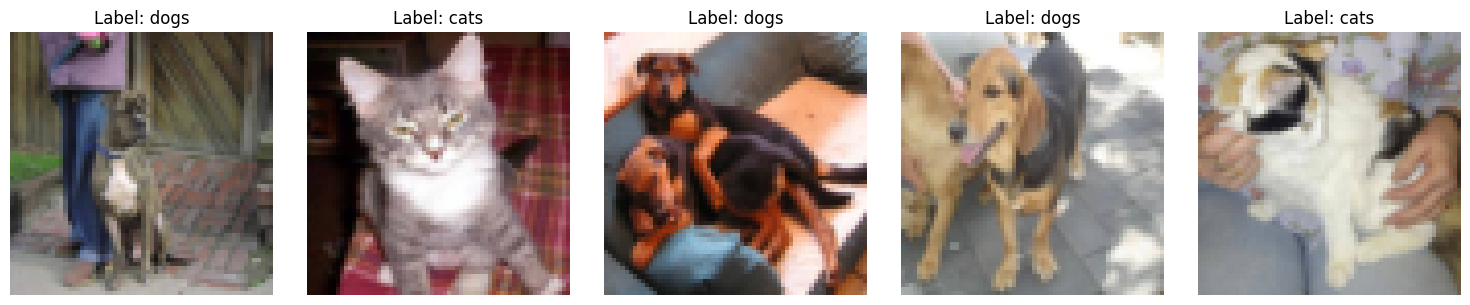

In [ ]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # denormalizacja
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

plain_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

plain_dataset = ImageFolder(data_dir, transform=plain_transform)
plain_loader = DataLoader(plain_dataset, batch_size=16, shuffle=True)

dataiter = iter(plain_loader)
images, labels = next(dataiter)

print("Przykładowe zdjęcia:")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i] / 2 + 0.5  
    npimg = img.numpy()
    axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[i].set_title(f"Label: {class_names[labels[i]]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [22]:
# Funkcja testująca
def test(model, loader, loss_fn, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc

In [24]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()

advanced_cnn = Model().to(device)
opt_advanced = torch.optim.Adam(advanced_cnn.parameters(), lr=0.0005)
writer = SummaryWriter("runs/dogcat_advancedcnn")

epochs = 60
train_losses_adv, val_losses_adv = [], []
train_accs_adv, val_accs_adv = [], []

for epoch in range(epochs):
    advanced_cnn.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        opt_advanced.zero_grad()
        outputs = advanced_cnn(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt_advanced.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_acc = test(advanced_cnn, plain_loader, loss_fn, device)
    print(f"Epoka {epoch+1}/{epochs} | Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    train_losses_adv.append(train_loss)
    val_losses_adv.append(val_loss)
    train_accs_adv.append(train_acc)
    val_accs_adv.append(val_acc)
writer.close()

Epoka 1/60 | Train loss: 0.6914, acc: 0.5722 | Val loss: 0.6346, acc: 0.6575
Epoka 2/60 | Train loss: 0.6112, acc: 0.6698 | Val loss: 0.5237, acc: 0.7540
Epoka 3/60 | Train loss: 0.5235, acc: 0.7405 | Val loss: 0.4371, acc: 0.7930
Epoka 4/60 | Train loss: 0.4509, acc: 0.7910 | Val loss: 0.4146, acc: 0.8084
Epoka 5/60 | Train loss: 0.3946, acc: 0.8259 | Val loss: 0.2990, acc: 0.8780
Epoka 6/60 | Train loss: 0.3474, acc: 0.8515 | Val loss: 0.3079, acc: 0.8790
Epoka 7/60 | Train loss: 0.3170, acc: 0.8655 | Val loss: 0.2565, acc: 0.8978
Epoka 8/60 | Train loss: 0.2973, acc: 0.8769 | Val loss: 0.2360, acc: 0.9168
Epoka 9/60 | Train loss: 0.2872, acc: 0.8798 | Val loss: 0.2855, acc: 0.9023
Epoka 10/60 | Train loss: 0.2682, acc: 0.8900 | Val loss: 0.2019, acc: 0.9281
Epoka 11/60 | Train loss: 0.2553, acc: 0.8957 | Val loss: 0.2058, acc: 0.9264
Epoka 12/60 | Train loss: 0.2506, acc: 0.8943 | Val loss: 0.1932, acc: 0.9315
Epoka 13/60 | Train loss: 0.2360, acc: 0.9040 | Val loss: 0.1693, acc: 0.

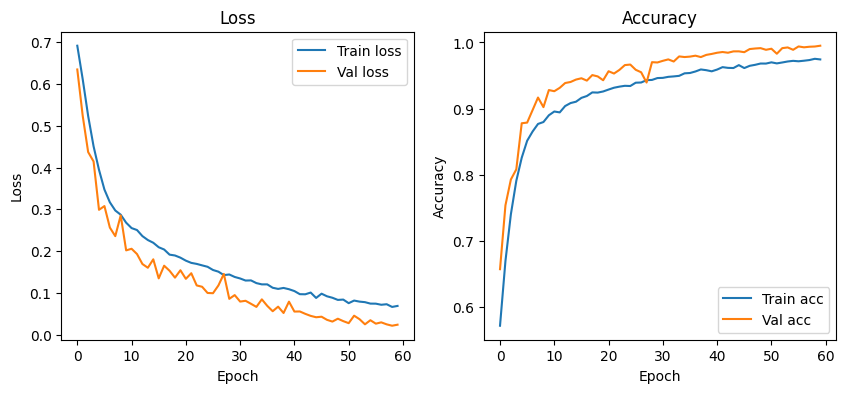


Najlepsze accuracy (val): 99.50%
Najlepszy loss (val): 0.0217
Ostatnia epoka - accuracy (val): 99.50% | loss (val): 0.0242


In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses_adv, label='Train loss')
plt.plot(val_losses_adv, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs_adv, label='Train acc')
plt.plot(val_accs_adv, label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

best_val_acc = max(val_accs_adv)
best_val_loss = min(val_losses_adv)
print(f"\nNajlepsze accuracy (val): {best_val_acc*100:.2f}%")
print(f"Najlepszy loss (val): {best_val_loss:.4f}")
print(f"Ostatnia epoka - accuracy (val): {val_accs_adv[-1]*100:.2f}% | loss (val): {val_losses_adv[-1]:.4f}")

In [ ]:
# Testowanie wytrenowanego modelu na danych testowych

test_data_dir = '/Users/franciszeklasinski/Desktop/dogvscat /archive-2/test'
test_dataset = datasets.ImageFolder(test_data_dir, transform=plain_transform) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

test_loss, test_acc = test(advanced_cnn, test_loader, loss_fn, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc*100:.2f}%")

Test loss: 0.1055, Test accuracy: 95.66%


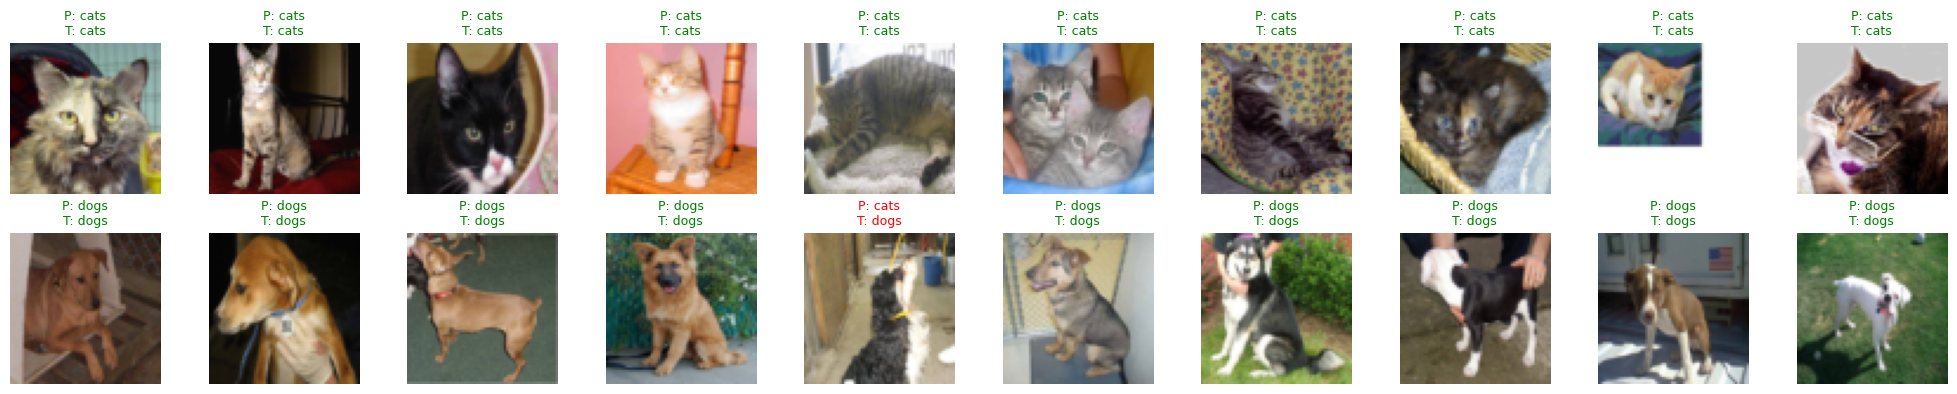

In [ ]:
cats, dogs = [], []
cat_idx = test_dataset.class_to_idx['cats']
dog_idx = test_dataset.class_to_idx['dogs']

for images, labels in test_loader:
    for img, label in zip(images, labels):
        if label.item() == cat_idx and len(cats) < 10:
            cats.append((img, label))
        elif label.item() == dog_idx and len(dogs) < 10:
            dogs.append((img, label))
        if len(cats) == 10 and len(dogs) == 10:
            break
    if len(cats) == 10 and len(dogs) == 10:
        break

samples = cats + dogs
imgs = torch.stack([img for img, _ in samples])
labels = torch.tensor([label for _, label in samples])

advanced_cnn.eval()
with torch.no_grad():
    outputs = advanced_cnn(imgs.to(device))
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(20, 4))
for i in range(20):
    img = imgs[i].clone()
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.subplot(2, 10, i+1)
    true_label = test_dataset.classes[labels[i]]
    pred_label = test_dataset.classes[preds[i].cpu()]
    color = 'green' if true_label == pred_label else 'red'
    plt.imshow(npimg)
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()